# Loading and correcting data for RhFe 
# P22 beamtime  in November 2018

In [1]:
%load_ext autoreload
%autoreload 2
%gui tk

In [2]:
#Imports
# Embedded imports
import os, sys
import copy
import math
import matplotlib.pyplot as plt
# Third party imports
import numpy as np
import pandas as pd
import scipy as sp
# Temporary solution for local imports
sys.path.append('..')
from xpstool import helpers 
from xpstool import Experiment, Spectrum, Region
from xpstool import Fitter

In [3]:
# Constants
p22_energy_3800 = 3800 # Photon energy from the p22 beamline
p22_energy_4600 = 4600 # Photon energy from the p22 beamline

In [4]:
# ---SCIENTA DATA FOLDERS---
# Full path to data files
data_folder = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/Data"
# Full path to output files
output_folder = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/ProcessedData"

file_names = []
file_idx = 0
for file in sorted(os.listdir(data_folder)):
    if file.endswith(".txt"):                         
        file_names.append(file)
        #print(f"---> file[{file_idx}]: {file}")
        file_idx += 1

**Files from 0000 to 0157 were measured at 4600 eV photon energy**

**File 0158 was measured at 3700 eV photon energy (IGNORE)**

**Files from 0159 to 0347 were measured at 3800 eV photon energy**

## <font color ='blue'>First experiment H2 : CO2 = 1 : 1 at ~50 mbar</font>

### Overview
Analyser properties: <br>
>    Slit = 0.8 (?) <br>
    Pass energy: 100 <br>
    <br>
    Experimental broadening consists of Gaussian broadening and Lorentzian broadening. The Gaussian FWHM can be obtained from the Fermi edge. Lorentzian contribution should be relaxed for fitting.

In [5]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0002",
    "0014",
    "0019",
    "0024",
    "0029",
    "0034",
    "0039",
    "0044",
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0004", "0003", "0005", "0007"],
    ["0011", "0008", "0013", "0012"],
    ["0016", "0015", "0018", "0017"],
    ["0021", "0020", "0023", "0022"],
    ["0025", "0026", "0028", "0027"],
    ["0031", "0030", "0033", "0032"],
    ["0036", "0035", "0038", "0037"],
    ["0041", "0040", "0043", "0042"]
]
conditions = [
    {"Temperature": "25 C"},
    {"Temperature": "150 C"},
    {"Temperature": "200 C"},
    {"Temperature": "250 C"},
    {"Temperature": "300 C"},
    {"Temperature": "350 C"},
    {"Temperature": "400 C"},
    {"Temperature": "450 C"}
]

# Create an Experiment object to store spectra specified above
exp = Experiment()
# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]),
                        conditions=conditions[i],
                        excitation_energy=p22_energy_4600)
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
            print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        exp.addSpectrum(spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]),
                            conditions=conditions[i],
                            excitation_energy=p22_energy_4600)
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            exp.addSpectrum(spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

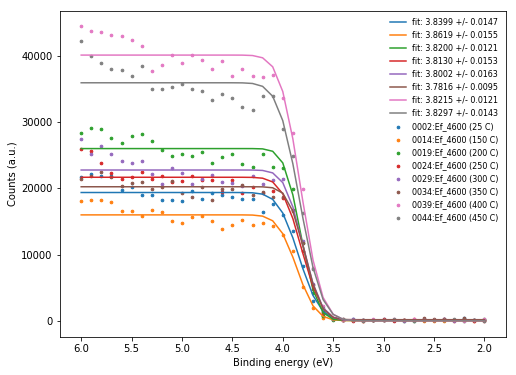

In [6]:
# Adjusting and plotting Fermi regions
shifts = [] # Contains energy shifts for every Fermi edge
gauss_fwhms = [] # Equipment gauss widening based on the Fermi edge
fig = plt.figure(1, figsize=(8,6))
for fermi in fermi_nums:
    fermi_region = exp.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding()
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       scatter=True, 
                       title=False)

    fit_parameters = [1, 3.8, 0.2, 20000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, 
                                   fit_parameters, 
                                   add_column=True)
    shifts.append([fit_res[0][1], fit_res[1][1]])
    # a2 parameter of the complementary error function is related to the
    # sigma parameter of the gaussian that can be constructed to describe
    # the widening of ideal step function. 
    # FWHM_gauss = 2*sqrt(ln2)*a2
    # FWHM_gauss = 2*sqrt(2ln2)*sigma
    gauss_fwhms.append([2*(math.log(2))**(.5)*abs(fit_res[0][2]), fit_res[1][2]])
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       y_data="fitFermi", 
                       label=f"fit: {fit_res[0][1]:.4f} +/- {fit_res[1][1]:.4f}", 
                       title=False)

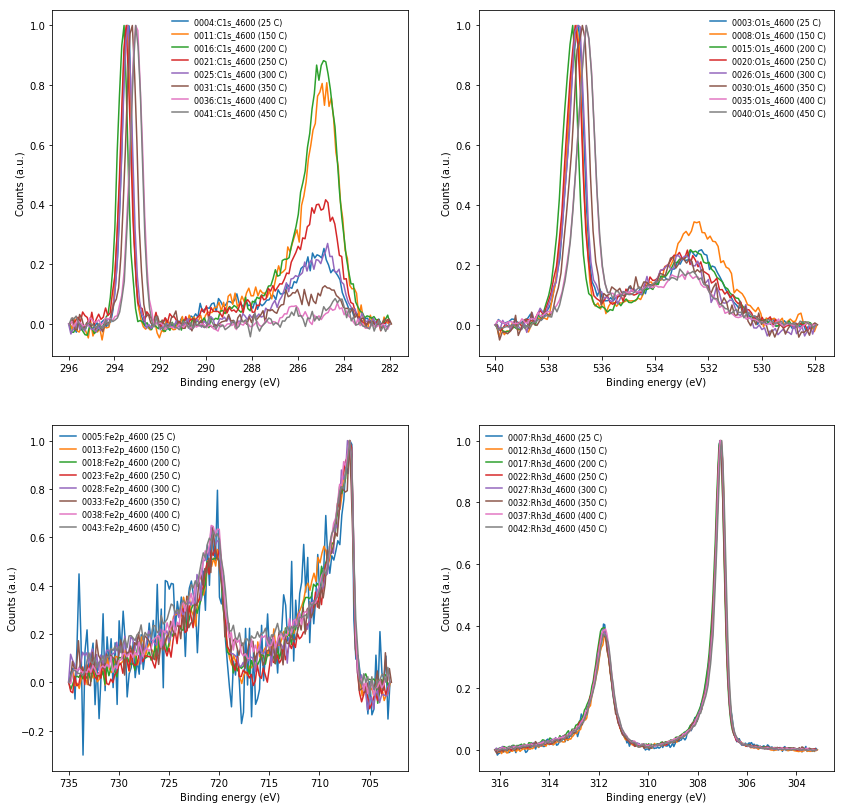

In [7]:
# Adjusting and plotting data overview
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
for i, single_set in enumerate(scan_sets): 
    for j, scan_num in enumerate(single_set):
        scan = exp.getSpectrum(scan_num).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()
        # Crop Fe2p regions
        if j == 2:
            scan.cropRegion(start=735, stop=703, changesource=True)
        # Crop O1s regions
        if j == 1:
            scan.cropRegion(start=540, stop=528, changesource=True)
        # Crop C1s regions
        if j == 0:
            scan.cropRegion(start=296, stop=282, changesource=True)
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
        helpers.calculateShirley(scan, y_data="counts", add_column=True)
        helpers.calculateLinearBackground(scan, y_data="shirleyBG", add_column=True)
        helpers.normalize(scan, y_data="linearBG", add_column=True)
        scan.makeFinalColumn("normalized", overwrite=True)
        # Plotting spectra
        helpers.plotRegion(scan, figure=fig.number, ax=ax[j], y_data="final", title=False)

### <font color ='red'>NOTE: Below we refine the linear background for C1s and O1s regions</font>

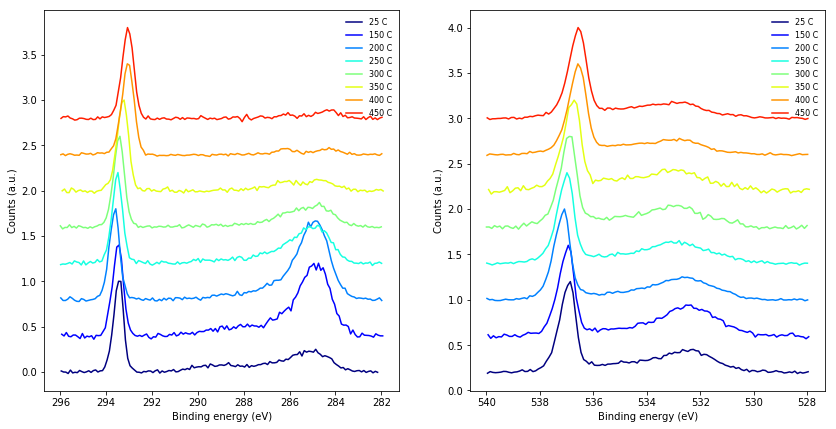

In [8]:
# Focusing on C1s and O1s regions
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = [ax1, ax2]
# Make sure that the colors are consistent through the experiment and that they
# are not repeated
NUM_COLORS = len(scan_sets)
cmap = plt.get_cmap('jet')
for axis in ax:
    axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i, single_set in enumerate(scan_sets): 
    for j, scan_file in enumerate(single_set[0:2]):
        scan = exp.getSpectrum(scan_file).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
        #helpers.calculateShirley(scan, y_data="counts", add_column=True)
        if j == 0:
            helpers.calculateLinearBackground(scan, 
                                  y_data="shirleyBG", 
                                  manual_bg=[[296,295],[282.7,282]],
                                  add_column=True)      
        if j == 1:
            helpers.calculateLinearBackground(scan, 
                                  y_data="shirleyBG", 
                                  manual_bg=[[540,539],[528.7,528]],
                                  add_column=True) 
        #helpers.calculateLinearBackground(scan, y_data="linearBG", add_column=True)
        helpers.normalize(scan, y_data="linearBG", add_column=True)
        scan.makeFinalColumn("normalized", overwrite=True)
        # Plotting spectra
        helpers.plotRegion(scan, 
                           figure=fig.number, 
                           ax=ax[j], 
                           y_offset=0.2*(2*i+j),
                           log_scale=False,
                           y_data="final", 
                           label=f"{scan.getConditions('Temperature')}", 
                           title=False)

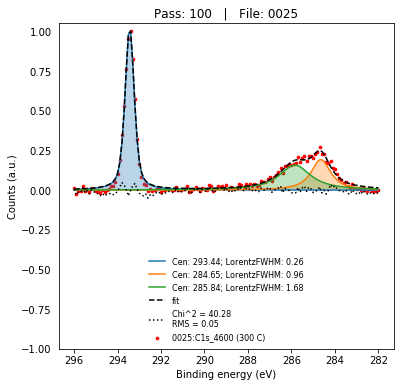

In [29]:
num = 4
# Fitting
fig = plt.figure(1, figsize=(6,6))
scan = exp.getSpectrum(scan_sets[num][0]).getRegion()
#scan = scan.cropRegion(start=292.5)
fitter = Fitter(scan, 
                y_data="final", 
                gauss_fwhm=gauss_fwhms[num][0])
initial_guess = [ # amp, cen, fwhm
    1, 293.3, 0.3,
    0.1, 284.7, 1,
    0.1, 286.2, 1
    #0.3, 285.7, 1 # Shall I add offset along Y???
    #500, 287.7, 2
]
fix_parameters = {
    "amp": [],
    "cen": [],
    "fwhm": []
}
fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
#print(fitter)
helpers.plotRegion(scan, y_data="final", color='red', scatter=True, legend_pos='lower center')
for peak in fitter.getPeaks():
    helpers.plotPeak(peak, legend_pos='lower center')
helpers.plotFit(fitter, addresiduals=True, legend_pos='lower center')
scan.addFitter(fitter, overwrite=True)

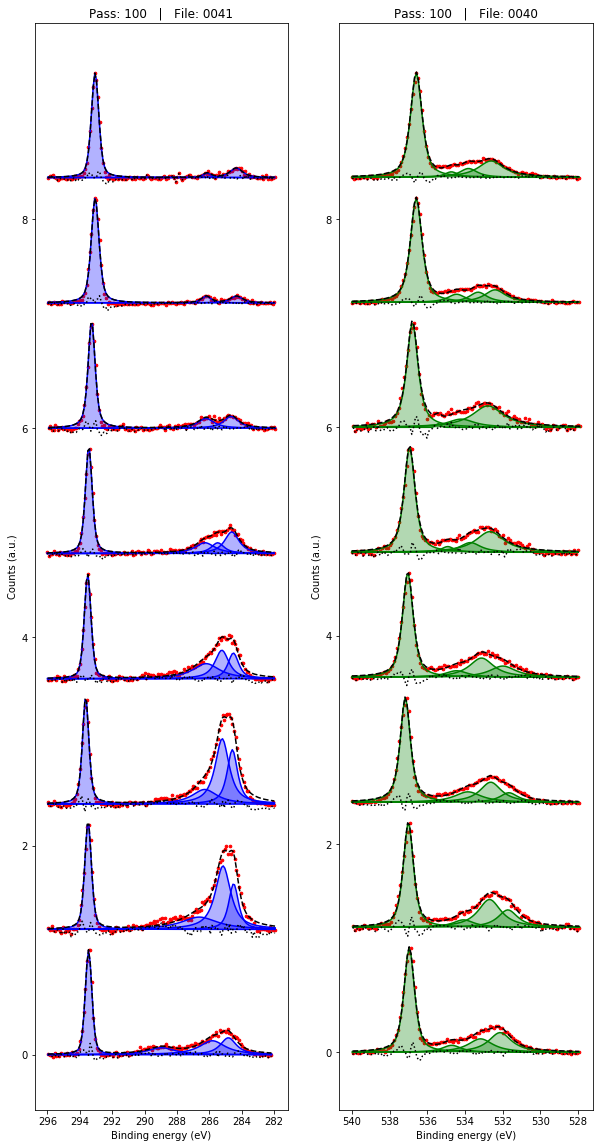

In [28]:
# Fitting of the desorption experiment
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,20))
# Populate C1s spectra
for i, set_ in enumerate(scan_sets):    
    scan = exp.getSpectrum(set_[0]).getRegion()
    fitter = Fitter(scan, 
                    y_data="final", 
                    gauss_fwhm=gauss_fwhms[i][0])
    if i < 4:
        initial_guess = [ # amp, cen, fwhm
            1, 293.3, 0.3,
            0.3, 284.6, 1,
            0.3, 285.2, 1,
            0.3, 286.2, 1
        ]        
    if i > 4:
        initial_guess = [ # amp, cen, fwhm
            1, 293.3, 0.3,
            0.1, 284.7, 1,
            0.1, 286.2, 1
        ]
    fix_parameters = {
        "amp": [],
        "cen": [],
        "fwhm": [],
    }
    helpers.plotRegion(scan, 
                       y_offset=1.2*i, 
                       figure=fig.number, 
                       ax=ax1, 
                       legend=False, 
                       y_data="final", 
                       color='red', 
                       scatter=True)
    if i < len(scan_sets):
        fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
        #print(fitter)
        for peak in fitter.getPeaks():
            helpers.plotPeak(peak, 
                             y_offset=1.2*i, 
                             figure=fig.number,
                             color="blue",
                             ax=ax1,
                             fill=True,
                             legend=False)
        helpers.plotFit(fitter, 
                        y_offset=1.2*i, 
                        figure=fig.number, 
                        ax=ax1, 
                        legend=False, 
                        addresiduals=True)
        scan.addFitter(fitter, overwrite=True)
# Populate O1s spectra
for i, set_ in enumerate(scan_sets):    
    scan = exp.getSpectrum(set_[1]).getRegion()
    fitter = Fitter(scan, 
                    y_data="final", 
                    gauss_fwhm=gauss_fwhms[i][0])
    initial_guess = [ # amp, cen, fwhm
        1, 537, 0.5,
        0.3, 532.59, 1,
        0.3, 533.91, 1,
        0.3, 535.6, 1
    ]
    fix_parameters = {
        "amp": [],
        "cen": [],
        "fwhm": [],
    }
    helpers.plotRegion(scan, 
                       y_offset=1.2*i, 
                       figure=fig.number, 
                       ax=ax2, 
                       legend=False, 
                       y_data="final", 
                       color='red', 
                       scatter=True)
    if i < len(scan_sets):
        fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
        #print(fitter)
        for peak in fitter.getPeaks():
            helpers.plotPeak(peak, 
                             y_offset=1.2*i, 
                             figure=fig.number,
                             color="green",
                             ax=ax2,
                             fill=True,
                             legend=False)
        helpers.plotFit(fitter, 
                        y_offset=1.2*i, 
                        figure=fig.number, 
                        ax=ax2, 
                        legend=False, 
                        addresiduals=True)
        scan.addFitter(fitter, overwrite=True)

### Experiment step by step

Start with the following flows <br>
<font color ='red'>CO2 -> 0.3 L/m <br>
H2 -> 0.3 L/m <br>
He -> 0.16 L/m <br></font>

#### 1. Room temperature <br>
First diff pumping stage pressure 5.6e-4 <br>
Files: <br>
>    Ef_4600 - 0002.txt <br>
    O1s_4600 - 0003.txt <br>
    C1s_4600 - 0004.txt <br>
    Fe2p_4600 - 0005.txt <br>
    Rh3d_4600 - 0007.txt <br>

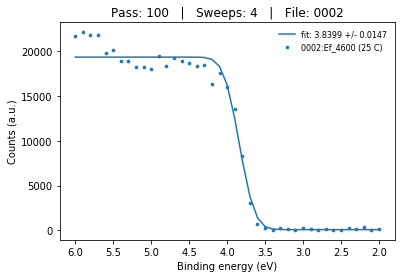

In [11]:
# Set #1
set_num = 0 
fermi_region = exp.getSpectrum(fermi_nums[set_num]).getRegion()
#gausspeak = helpers.calculateFermiGaussian(fermi_region)
#gauss_sigma = gausspeak.getParameters("sigma")
helpers.plotRegion(fermi_region, 
                   figure=1, 
                   scatter=True)
helpers.plotRegion(fermi_region, 
                   figure=1, 
                   y_data="fitFermi", 
                   label=f"fit: {shifts[set_num][0]:.4f} +/- {shifts[set_num][1]:.4f}")
#helpers.plotPeak(gausspeak, figure=1, label=f"sigma={gauss_sigma:.4f}")

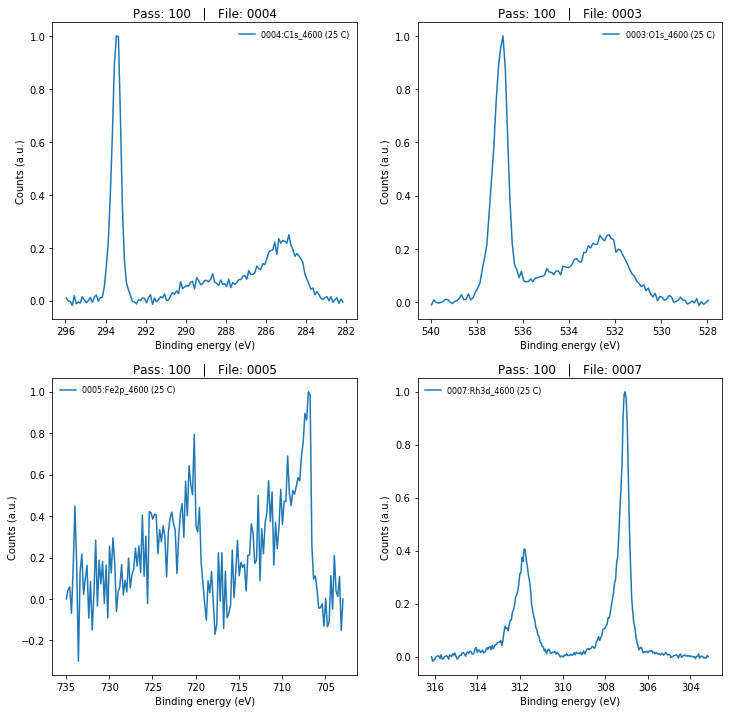

In [12]:
# Plotting set of spectra at the same conditions
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax = [ax1, ax2, ax3, ax4]
for i, scan_num in enumerate(scan_sets[set_num]):
    # Plotting corrected spectra
    helpers.plotRegion(exp.getSpectrum(scan_num).getRegion(),
                       figure=fig.number, 
                       ax=ax[i], y_data="final")

17
Region 0025:C1s_4600 already has a fitter. Add overwrite=True parameter to overwrite.


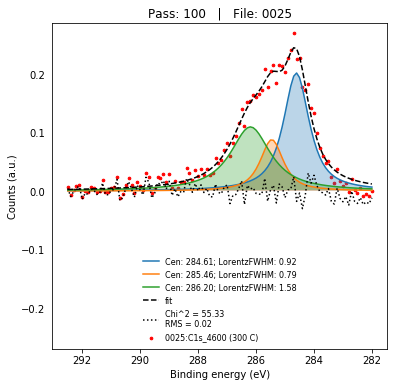

In [13]:
fig = plt.figure(1, figsize=(6,6))
scan = exp.getSpectrum(scan_sets[4][0]).getRegion()
scan = scan.cropRegion(start=292.5)
print(scan.getInfo("Sweeps Number"))
fitter = Fitter(scan, 
                y_data="final", 
                gauss_fwhm=gauss_fwhms[set_num][0])
initial_guess = [ # amp, cen, fwhm
    0.5, 284.7, 0.3,
    0.5, 285.7, 0.3,
    0.5, 286.7, 0.3 # Shall I add offset along Y???
    #500, 287.7, 2
]
fix_parameters = {
    "amp": [],
    "cen": [],
    "fwhm": []
}
fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
#print(fitter)
helpers.plotRegion(scan, y_data="final", color='red', scatter=True, legend_pos='lower center')
for peak in fitter.getPeaks():
    helpers.plotPeak(peak, legend_pos='lower center')
helpers.plotFit(fitter, addresiduals=True, legend_pos='lower center')
scan.addFitter(fitter)

#### 2. 150 C <br>
CO2 -> 0.3 L/m <br>
H2 -> 0.3 L/m <br>
He -> 0.16 L/m <br>
First diff pumping stage pressure 3.3e-4 <br>
Files: <br>
>    Ef_4600 - 0014.txt <br>
    O1s_4600 - 0008.txt <br>
    C1s_4600 - 0011.txt <br>
    Fe2p_4600 - 0013.txt <br>
    Rh3d_4600 - 0012.txt <br>